# Installations

In [1]:
! pip -q install datasets evaluate
! pip -q install --upgrade accelerate
! pip install -q kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [2]:
! pip install -q datasets huggingface_hub
! pip install --upgrade -q transformers
! pip install -q onnx onnxruntime onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.2 MB/s eta 0:00:00


## Data Downloading

In [3]:
import torch
import torchvision
import gradio as gr
from PIL import Image
import numpy as np
import evaluate
from datasets import load_dataset
from huggingface_hub import notebook_login
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import DefaultDataCollator
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Resize, Compose, Normalize, ToTensor, RandomHorizontalFlip
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt


**To obtain the kaggle.json file, go to kaggle.com, then under settings, go to the API section.**

In [ ]:
# Before running this cell, upload your kaggle.json file to /content

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/


In [ ]:
! cat /root/.kaggle/kaggle.json


{"username":"plan09","key":"KGAT_bea43d5d51181722fec0da25443c595b"}

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset


Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset
License(s): CC0-1.0
 99% 1.24G/1.25G [00:16<00:00, 23.5MB/s]
100% 1.25G/1.25G [00:16<00:00, 79.1MB/s]


In [ ]:
! unzip "/content/plant-disease-recognition-dataset.zip" -d "/content/dataset/"


## Dataset Loading

#### image label (0---> healthy, 1---> powdery, 2----> rusty)

In [ ]:
plant_dataset = load_dataset('imagefolder', data_dir='/content/dataset')


Resolving data files:   0%|          | 0/1532 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
plant_dataset


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1532
    })
})

In [4]:
# Login to Huggingface

notebook_login()


In [ ]:
# Push the dataset to HF Hub

repo_name = "plant-dataset" # Replace with your desired dataset name
plant_dataset.push_to_hub (repo_name)


Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ? shards/s]

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   6%|6         | 30.1MB /  466MB            

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   3%|3         | 13.9MB /  447MB            

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   5%|5         | 22.6MB /  440MB            

CommitInfo(commit_url='https://huggingface.co/datasets/Plan-9/plant-dataset/commit/a97fa5bd31a1c4dea3f69400faf6c46e9bfa12cf', commit_message='Upload dataset', commit_description='', oid='a97fa5bd31a1c4dea3f69400faf6c46e9bfa12cf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Plan-9/plant-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Plan-9/plant-dataset'), pr_revision=None, pr_num=None)

In [ ]:
# Download the dataset from your HF Hub

# Change the name below to your HF user name

full_dataset = load_dataset ("Plan-9/plant-dataset", split="train")


In [ ]:
full_dataset


Dataset({
    features: ['image', 'label'],
    num_rows: 1532
})

## Data Splitting

In [ ]:
# Split the dataset into training and the remainder (validation + test)
train_rest = full_dataset.train_test_split (test_size=0.2)

# Split the remainder (validation + test) into validation and test sets
test_valid = train_rest['test'].train_test_split (test_size=0.5)

# Assign the splits to new variables
train_dataset = train_rest['train']
validation_dataset = test_valid['train']
test_dataset = test_valid['test']

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(validation_dataset))
print("Test dataset size:", len(test_dataset))


Training dataset size: 1225
Validation dataset size: 153
Test dataset size: 154


## Data Visualization

In [7]:
label_names = {
   0: "healthy",
   1: "powdery",
   2: "rusty",
}

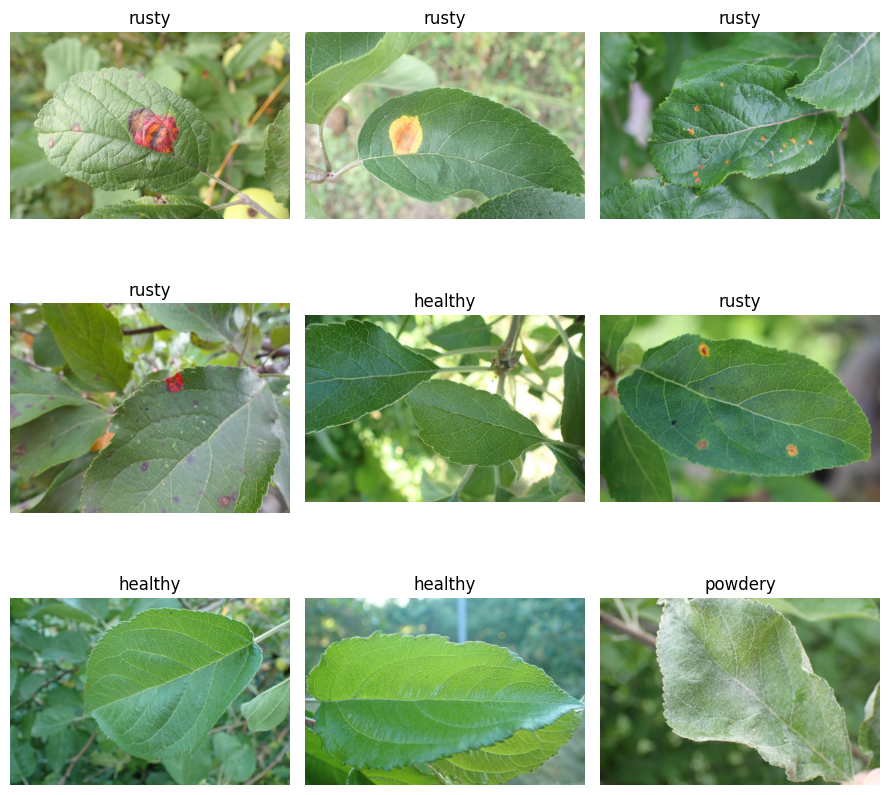

In [ ]:
# Visualize some images
num_rows = 3
num_cols = 3

plt.figure(figsize=(num_cols * 3, num_rows * 3))

indices = np.random.choice(range(len(train_dataset)), size=9, replace=False)

for i, idx in enumerate(indices, 1):
    idx = int(idx)
    image = train_dataset[idx]['image']
    label = train_dataset[idx]['label']

    plt.subplot(num_rows, num_cols, i)
    plt.imshow(image)
    plt.title(label_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data Preprocessing

In [ ]:
checkpoint = "google/vit-base-patch16-224-in21k"  # ViT Model at HF
image_processor = AutoImageProcessor.from_pretrained(checkpoint)  # Get the image processor from HF
normalize = Normalize (mean=image_processor.image_mean, std=image_processor.image_std)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


#### Create the dataset transforms, and apply them

In [ ]:
train_transforms = Compose ([
    RandomResizedCrop((224, 224)),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    normalize
])

val_transforms = Compose ([
    Resize((224, 224)),
    ToTensor(),
    normalize
])

def apply_transforms(examples):
    examples["pixel_values"] = [train_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples


In [ ]:
train_data = train_dataset.with_transform (apply_transforms)
val_data = validation_dataset.with_transform (apply_val_transforms)
test_data = test_dataset.with_transform (apply_val_transforms)

data_collator = DefaultDataCollator () # For batching during training


# Modeling and Training

In [8]:
id2label = label_names
label2id = {v: k for k, v in id2label.items()}
print(id2label, label2id)


{0: 'healthy', 1: 'powdery', 2: 'rusty'} {'healthy': 0, 'powdery': 1, 'rusty': 2}


In [ ]:
model = AutoModelForImageClassification.from_pretrained (
    checkpoint,
    num_labels = 3,
    id2label = id2label,
    label2id = label2id,
)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
accuracy = evaluate.load("accuracy")

def compute_metrics (evaluation_data):
    predictions, labels = evaluation_data
    predictions = np.argmax (predictions, axis=1) # Index of largest values
    return accuracy.compute (predictions=predictions, references=labels)


In [ ]:
training_args = TrainingArguments(
    output_dir = "./plant_outputs",
    remove_unused_columns = False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 5e-5,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    per_device_eval_batch_size = 2,
    num_train_epochs = 3,
    warmup_ratio = 0.1, # How much to increase the LR on each epoch
    logging_steps = 10,
    load_best_model_at_end = True,
    push_to_hub = True,
)


In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_data,
    eval_dataset = val_data,
    tokenizer = image_processor,
    compute_metrics = compute_metrics,
)


/tmp/ipython-input-4255450586.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: plan-9 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, mcp] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Epoch,Training Loss,Validation Loss,Accuracy
1,0.088600,0.045640,1.000000
2,0.174300,0.040486,0.993464
3,0.082800,0.030184,0.993464


TrainOutput(global_step=462, training_loss=0.1961951582204728, metrics={'train_runtime': 821.1033, 'train_samples_per_second': 4.476, 'train_steps_per_second': 0.563, 'total_flos': 2.847856142541312e+17, 'train_loss': 0.1961951582204728, 'epoch': 3.0})

In [ ]:
outputs = trainer.predict(val_data)
print(outputs.metrics)


{'test_loss': 0.030184078961610794, 'test_accuracy': 0.9934640522875817, 'test_runtime': 24.4806, 'test_samples_per_second': 6.25, 'test_steps_per_second': 3.145}


In [ ]:
outputs_test = trainer.predict(test_data)
print(outputs_test.metrics)


{'test_loss': 0.03089415654540062, 'test_accuracy': 1.0, 'test_runtime': 47.5788, 'test_samples_per_second': 3.237, 'test_steps_per_second': 1.618}


In [ ]:
model.push_to_hub("vit-plant-disease-classification")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...da4vq06/model.safetensors:   5%|4         | 16.8MB /  343MB            

CommitInfo(commit_url='https://huggingface.co/Plan-9/vit-plant-disease-classification/commit/5aeb2942bef369c0d4dc53959b052c8be8e5ec91', commit_message='Upload ViTForImageClassification', commit_description='', oid='5aeb2942bef369c0d4dc53959b052c8be8e5ec91', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Plan-9/vit-plant-disease-classification', endpoint='https://huggingface.co', repo_type='model', repo_id='Plan-9/vit-plant-disease-classification'), pr_revision=None, pr_num=None)

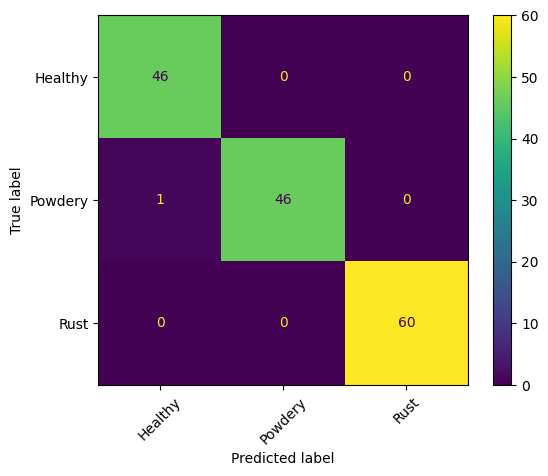

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = test_data.features["label"].names

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45);


In [ ]:
# Create the pipeline

# Change the name below to your HF username

from transformers import pipeline, AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
pipe = pipeline("image-classification", model="Plan-9/vit-plant-disease-classification", image_processor=processor)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Test with an image

predictions = pipe("/content/81a3b719b6c2b4da.jpg")


In [ ]:
print(predictions)

[{'label': 'powdery', 'score': 0.9787449836730957}, {'label': 'healthy', 'score': 0.012157419696450233}, {'label': 'rusty', 'score': 0.009097578935325146}]


In [10]:
def predict_disease(image):
  if image is None:
    return "Please upload an image."
  try:
    prediction = pipe(image)
    result = prediction[0]['label']
    return f"Prediction: {result}"
  except Exception as e:
    return f"An error occurred during prediction: {e}"


# Gradio Application

In [ ]:
# Gradio user interface
iface = gr.Interface (
    fn = predict_disease,
    inputs = gr.Image(
        type = "pil",
        label = "Upload Plant Image"
    ),
    outputs = gr.Textbox(
        label = "Classification Result"
    ),
    title = "Plant Disease Classifier (Healthy, Powdery, or Rusty)",
    description = "Upload an image of a plant leaf. The system will classify its condition.",
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dfc43639ec621145e7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [11]:
# Dowload your model from HF
# Change to your HF model name
model = AutoModelForImageClassification.from_pretrained("Plan-9/vit-plant-disease-classification", return_dict=True)
# processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [13]:
example_input = torch.randn(1, 3, 224, 224) # image shape , device='cpu')
input_names = ["pixel_values"]
output_names = ["logits"]
onnx_file_path = "vit_classification.onnx"


In [ ]:
torch.onnx.export (
    model,
    example_input,
    onnx_file_path,
    export_params = True,         # store the trained parameter weights inside the onnx file
    opset_version = 18, # 14      # the ONNX version to export the model to
    do_constant_folding = True,   # whether to execute constant folding for optimization
    input_names = input_names,    # the model's input names
    output_names = output_names,  # the model's output names
    # dynamic batch size
    dynamic_axes = {"pixel_values": {0: "batch_size"}, "logits": {0: "batch_size"}},
)


In [ ]:
image_path = "/content/8def4d91382175c3.jpg"
test_img = Image.open(image_path)

# Perform the pre-processing manually
resized_img = test_img.resize((224, 224))
np_array = np.asarray(resized_img)
img = np.transpose(np_array, (2, 0, 1)) # 224, 224, 3 (channels last) ---> 3, 224, 224 (channels first)
img = np.expand_dims(img, axis=0)       # add batch dimension ---> 1, 3, 224, 224
img = img.astype(np.float32) / 255.0    # rescale the image data (0 to 1)


In [15]:
import onnxruntime as ort
import onnxscript


In [ ]:
# Create an ONNX runtime session (for CPU)

providers = ['CPUExecutionProvider'] # 'CUDAExecutionProvider' (for GPU)
session = ort.InferenceSession("vit_classification.onnx", providers=providers)


In [ ]:
session_input = {session.get_inputs()[0].name: img}


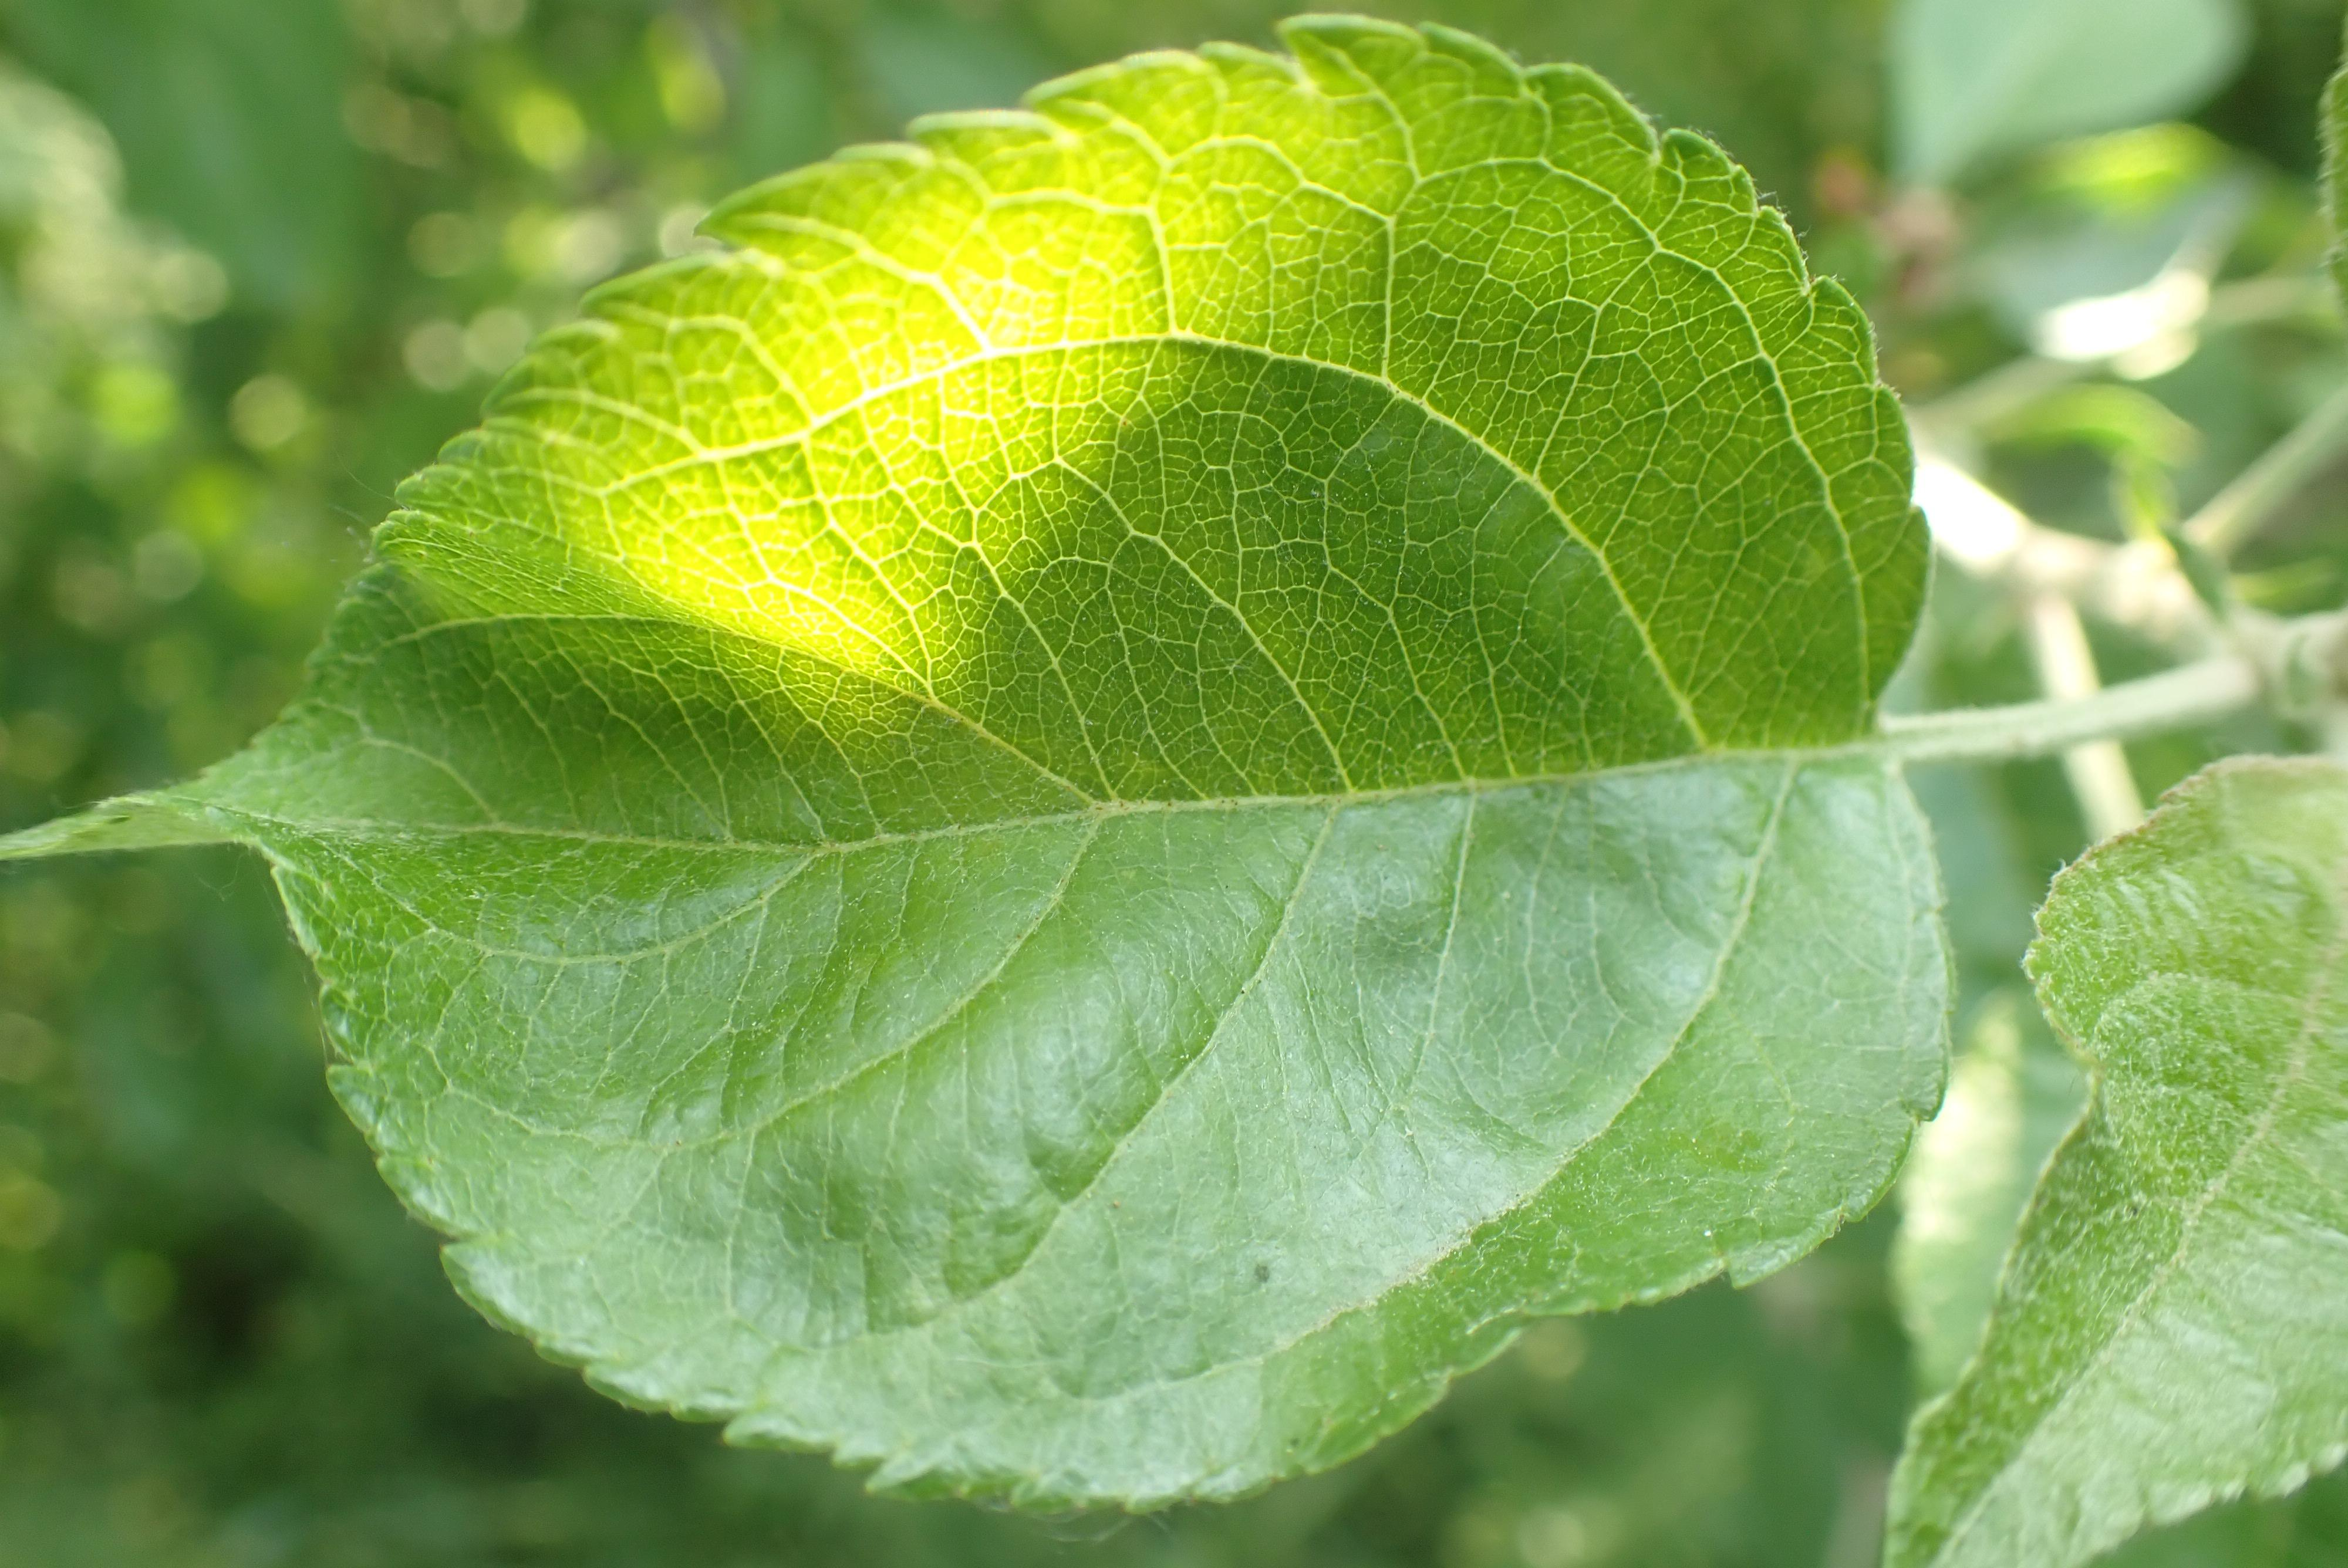

[array([[ 2.5881195, -1.3717474, -1.5793744]], dtype=float32)]
[[ 2.5881195 -1.3717474 -1.5793744]]
0


In [ ]:

from IPython.display import Image as DisplayImage
display(DisplayImage(filename=image_path, width=500, height=300))

onnx_output = session.run(None, session_input)
print(onnx_output)

onnx_logits = onnx_output[0]
print(onnx_logits)

# get the class with the highest probability
onnx_pred_idx = np.argmax(onnx_logits, axis=1)[0]
print(onnx_pred_idx)


In [ ]:
label_names

{0: 'healthy', 1: 'powdery', 2: 'rusty'}

In [16]:
import torch
from transformers import ViTForImageClassification, AutoImageProcessor
from pathlib import Path

# --- Configuration ---
MODEL_ID = "Plan-9/vit-plant-disease-classification"
ONNX_MODEL_PATH = Path("vit_classification.onnx")

# --- Load Model and Preprocessor ---
# Set return_dict=False for simpler ONNX tracing
model = AutoModelForImageClassification.from_pretrained(MODEL_ID, return_dict=True)
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Create an example input tensor for tracing
# The model expects pixel values (batch_size, channels, height, width)
example_input = torch.randn(1, 3, 224, 224)

# --- Define Input and Output Names ---
# These names are crucial for the ONNX graph
input_names = ["pixel_values"]
output_names = ["logits"]

# --- Export to ONNX ---
print(f"Starting ONNX export to {ONNX_MODEL_PATH}")

torch.onnx.export(
    model,
    example_input,
    ONNX_MODEL_PATH,
    export_params=True,  # Store model parameters
    opset_version=18,    # Recommended ONNX OpSet version
    do_constant_folding=True,
    input_names=input_names,
    output_names=output_names,
    # Define the input shape: [batch_size, channels, height, width]
    dynamic_axes={"pixel_values": {0: "batch_size"}, "logits": {0: "batch_size"}},
)

print(f"ONNX model successfully saved to {ONNX_MODEL_PATH.name}")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Starting ONNX export to vit_classification.onnx


/tmp/ipython-input-3587206898.py:26: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ViTForImageClassification([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ViTForImageClassification([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 51 of general pattern rewrite rules.
ONNX model successfully saved to vit_classification.onnx


In [18]:
! ls -l vit*

-rw-r--r-- 1 root root   1204053 Jan 10 18:04 vit_classification.onnx
-rw-r--r-- 1 root root 343212032 Jan 10 18:04 vit_classification.onnx.data


In [21]:
from PIL import Image
import numpy as np
import onnxruntime as ort

# Load an uploaded image (replace 'wedding_demo.jpg' if you use a different name)
try:
    image = Image.open("/content/81a3b719b6c2b4da.jpg").convert("RGB")
except FileNotFoundError:
    print("Error: image not found. Please ensure the file is in the correct directory.")
    # Create a dummy white image if the file is missing for demonstration continuation
    image = Image.new('RGB', (224, 224), color = 'white')

# Preprocess the image using the same processor used for the PyTorch model
inputs = processor(images=image, return_tensors="pt")
# The pixel values tensor is the exact input needed for the ONNX model
onnx_input = inputs["pixel_values"].numpy()


In [22]:
onnx_input.shape

(1, 3, 224, 224)

In [30]:
img = Image.open("/content/830f26cc6d3cd13e.jpg")

# Transform the image
resized_img = img.resize((224, 224))
numpy_array = np.asarray(resized_img)
img = np.transpose(numpy_array, (2, 0, 1))
img = np.expand_dims(img, axis=0)
img = img.astype(np.float32) / 255.0
print(img.shape)

(1, 3, 224, 224)


In [31]:
resized_img.size

(224, 224)

In [32]:
def create_session():
   session_options = ort.SessionOptions()
   provider_options = None
   providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
   session = ort.InferenceSession("model.onnx",
                  sess_options=session_options,
                  provider_options=provider_options, providers=providers)

In [33]:
import onnxruntime as ort
from PIL import Image
import numpy as np

# Load the ONNX model with ONNX Runtime
# Try loading the FP32 model first to isolate the issue
providers = ['CPUExecutionProvider']
session = ort.InferenceSession("vit_classification.onnx", providers=providers)
session_input = {session.get_inputs()[0].name: img}

# Run the ONNX model
onnx_output = session.run(None, session_input)
onnx_logits = onnx_output[0]

# Get the predicted class index
onnx_pred_index = np.argmax(onnx_logits, axis=1)[0]
onnx_score = np.max(onnx_logits)


In [35]:
print(onnx_score, onnx_logits, onnx_pred_index)

3.0445175 [[-1.4993558 -1.0704466  3.0445175]] 2


# Run a timing test between the PyTorch model and the ONNX model

In [37]:
import time

In [40]:

# Run 1000 tests and get the average run time (ONNX model)
time_sum = 0
iterations = 100

onnx_model_path = "/content/vit_classification.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

providers = ['CPUExecutionProvider']
session = ort.InferenceSession (onnx_model_path, providers=providers)
session_input = {session.get_inputs()[0].name: img} # use same image each time

for i in range (iterations):
  # put logic here to use a different input each time
  # session_input = {session.get_inputs()[0].name: xxxxx}
  t0 = time.time()
  onnx_output = session.run(None, session_input)
  time_sum += (time.time() - t0)
  if (i == 25): print(i)

print(f"Total time: {time_sum / iterations}")


25
Total time: 0.466477792263031
